In [1]:
from joblib import Parallel, delayed
from __init__ import *
from Setting import *
from utils import *

### Pnl

In [2]:
Pnl = {}
total_d_gain = pd.Series([])
total_d_gain = total_d_gain.reindex(BACKTEST_VTD).fillna(0)

In [3]:
for com in commodities.keys():
    com_balance= pd.read_csv(f'output/balance_sheet/{com}_balance.csv')
    com_balance = com_balance.set_index(com_balance.columns[0])
    Pnl[com] = com_balance['Pnl']
    total_d_gain += com_balance['d_gain']

Pnl['total'] = 1 + total_d_gain.cumsum()/(len(commodities.keys()) * INIT_CAP)

In [4]:
def draw_pnl(scom):
    fig, axes = plt.subplots(figsize=(10, 5), dpi=80)
    plt.title(f'{scom} Pnl')
    Pnl[scom].plot()

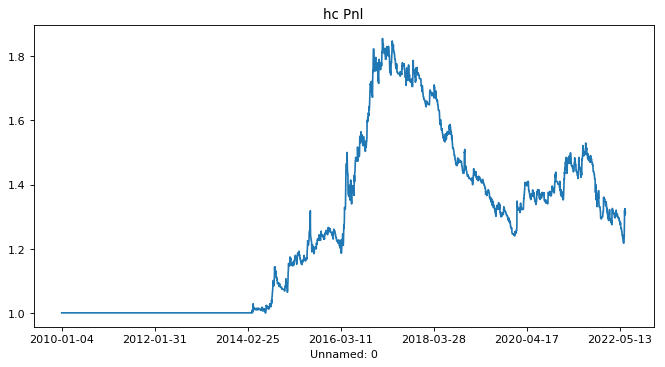

In [5]:
draw_pnl('hc')

### Win-Loss

In [6]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

In [7]:
for com in commodities.keys():
    com_log = np.load(f'output/trading_logs/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

    all_buy = all_buy.append(com_log[0])
    all_sell = all_sell.append(com_log[1])
    all_total = all_total.append(com_log[2])

trading_logs['all'] = [all_buy, all_sell, all_total]

In [8]:
def cal_win_rate(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].shape[0] / _df_['gain'].shape[0], 4)

def cal_win_loss_ratio(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].sum() / _df_['gain'].loc[_df_['gain']<0].sum() * -1, 4)

In [9]:
cols = ['BUY_wr', 'SELL_wr', 'TOTAL_wr', 'BUY_wlr', 'SELL_wlr', 'TOTAL_wlr']
symbols = list(commodities.keys())+['all']

In [10]:
Win_Loss_Analysis = pd.DataFrame(columns=symbols)
WLA = Win_Loss_Analysis.reindex(cols).transpose()

In [11]:
for com in symbols:
    buy_log = trading_logs[com][0]
    sell_log= trading_logs[com][1]
    total_log = trading_logs[com][2]

    WLA['BUY_wr'][com] = cal_win_rate(buy_log)
    WLA['SELL_wr'][com] = cal_win_rate(sell_log)
    WLA['TOTAL_wr'][com] = cal_win_rate(total_log)

    WLA['BUY_wlr'][com] = cal_win_loss_ratio(buy_log)
    WLA['SELL_wlr'][com] = cal_win_loss_ratio(sell_log)
    WLA['TOTAL_wlr'][com] = cal_win_loss_ratio(total_log)

In [12]:
WLA

,BUY_wr,SELL_wr,TOTAL_wr,BUY_wlr,SELL_wlr,TOTAL_wlr
rb,0.2899,0.2775,0.2838,1.3206,1.3317,1.3252
hc,0.2807,0.2358,0.2571,1.0897,0.8732,1.0056
i,0.2584,0.2253,0.241,1.2959,1.1969,1.2497
m,0.2402,0.2471,0.2435,1.1497,0.8742,1.0293
pp,0.2206,0.2434,0.2314,1.0097,1.1827,1.0874
MA,0.2364,0.2443,0.2404,1.104,0.9911,1.0533
bu,0.2494,0.2474,0.2483,0.9884,0.9414,0.9638
l,0.2336,0.2299,0.2317,0.7979,0.9944,0.8854
p,0.2459,0.2366,0.2411,1.1512,1.0744,1.1235
v,0.2642,0.2421,0.2529,1.1118,0.9103,1.0265


### Positions

#### Positions Holding Time

In [13]:
hold_t = {}
all_hold_t = []
all_hold_t = pd.Series(all_hold_t)

for com in commodities.keys():
    _df = trading_logs[com][2].copy(deep=True)

    delta_t = pd.to_datetime(_df['close_date']) - pd.to_datetime(_df['open_date'])
    _df['hold_t'] = (delta_t).apply(lambda x: x.total_seconds()/60)

    hold_t[com] = _df['hold_t']
    all_hold_t = all_hold_t.append(_df['hold_t'])

hold_t['all'] = all_hold_t

In [14]:
def hold_t_analysis(scom):
    ht = hold_t[scom]
    print(ht.describe())
    ht.hist(bins=20)

count      948.000000
mean      2507.848101
std       3802.023694
min          0.000000
25%          0.000000
50%       1440.000000
75%       4320.000000
max      33120.000000
Name: hold_t, dtype: float64


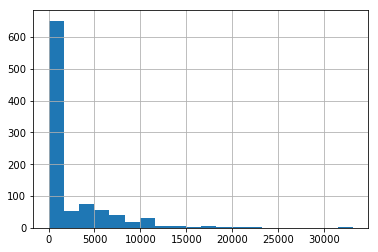

In [15]:
hold_t_analysis('rb')

In [16]:
cols_2 = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max']
HTA = pd.DataFrame(columns=symbols)
HTA = HTA.reindex(cols_2).transpose()

In [17]:
for com in symbols:
    ht = hold_t[com]
    des = list(ht.describe())
    for i in cols_2:
        HTA[i][com] = round(int(des[cols_2.index(i)])/60, 1) if cols_2.index(i)>0 else des[cols_2.index(i)]

In [18]:
HTA # Holding Period Time

,count,mean,std,min,25%,50%,75%,max
rb,948,41.8,63.4,0,0,24,72,552
hc,840,31.7,52.7,0,0,0,48,432
i,693,38.2,62.4,0,0,24,48,504
m,1072,39,57.9,0,0,24,48,384
pp,644,40.9,64.4,0,0,24,48,432
MA,778,33.4,57.7,0,0,0,48,600
bu,882,33.9,52.8,0,0,24,48,408
l,863,42.4,68.4,0,0,24,48,672
p,1149,38.5,66.6,0,0,24,48,648
v,945,40.9,63,0,0,24,48,504


#### Daily Trade Num

In [19]:
trade_num = {}
all_trade_num = pd.Series([0 for i in range(len(BACKTEST_VTD))])

for com in commodities.keys():
    tn = [0 for i in range(len(BACKTEST_VTD))]
    com_log = trading_logs[com]
    _df = com_log[2].copy(deep=True)

    for i in range(_df.shape[0]):
        entry = _df.iloc[i]
        tn[BACKTEST_VTD.index(entry['open_date'])] += 1
        tn[BACKTEST_VTD.index(entry['close_date'])] += 1
    
    trade_num[com] = tn
    all_trade_num += pd.Series(tn)

trade_num['all'] = all_trade_num.to_list()

In [20]:
DTN = pd.DataFrame()
DTN = DTN.reindex(BACKTEST_VTD)

for com in symbols:
    DTN[com] = trade_num[com]

In [21]:
DTN # Daily Trade Num

,rb,hc,i,m,pp,MA,bu,l,p,v,CF,OI,SR,TA,SA,all
2010-01-04,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2010-01-05,0,0,0,0,0,0,0,0,0,2,0,0,2,2,0,6
2010-01-06,1,0,0,0,0,0,0,2,0,2,0,0,2,0,0,7
2010-01-07,2,0,0,1,0,0,0,1,1,2,0,0,1,0,0,8
2010-01-08,0,0,0,0,0,0,0,0,0,1,3,0,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-20,1,0,0,1,0,0,1,0,0,0,2,2,0,2,3,12
2022-06-21,2,0,0,3,1,0,1,0,0,0,0,0,2,1,0,10
2022-06-22,1,0,0,5,1,0,1,0,2,2,1,0,0,3,2,18
2022-06-23,1,1,1,0,4,1,1,0,0,0,0,0,0,1,1,11


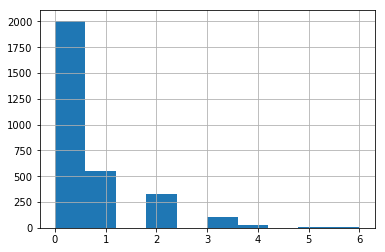

In [22]:
DTN['hc'].hist()

#### Features and Signals

In [26]:
def Judge_Pos(com):
    ddf = pd.read_csv(f'output/features/{com}_features.csv')
    ddf = ddf.set_index('CLOCK.1')

    ddf['signal'] = np.zeros(ddf.shape[0])
    clock_list = ddf['CLOCK'].to_list()

    for i in range(trading_logs['rb'][0].shape[0]):
        entry = trading_logs['rb'][0].iloc[i]
        start = entry['open_bar']
        end = entry['close_bar']
        ddf['signal'].loc[start: end] = 1

    for i in range(trading_logs['rb'][1].shape[0]):
        entry = trading_logs['rb'][1].iloc[i]
        start = entry['open_bar']
        end = entry['close_bar']
        ddf['signal'].loc[start: end] = -1

    return ddf

In [27]:
F_data=  {}
tasks = []
## Positions
for com in commodities.keys():
    tasks.append(delayed(Judge_Pos)(com))

multi_work = Parallel(n_jobs=8, backend='threading', verbose=80)
res = multi_work(tasks)

for com in commodities.keys():
    F_data[com] = res[list(commodities.keys()).index(com)]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:    6.1s remaining:   40.3s
[Parallel(n_jobs=8)]: Done   3 out of  15 | elapsed:    6.3s remaining:   25.4s
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    6.3s remaining:   17.5s
[Parallel(n_jobs=8)]: Done   5 out of  15 | elapsed:    6.3s remaining:   12.8s
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=8)]: Done   7 out of  15 | elapsed:    6.6s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    6.6s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   9 out of  15 | elapsed:   10.9s remaining:    7.2s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:   11.0s remaining:    5.5s
[Parallel(n_jobs=8)]: Done  11 out of  15 | elapsed:   11.3s remaining:    4.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   11.5

In [80]:
def plot_all(scom, t_start, t_end):
    stmp = F_data[scom][t_start:t_end].copy(deep=True)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5), dpi=150, sharex=True)
    axes[0].tick_params(labelsize=7)
    axes[1].tick_params(labelsize=7)

    ## K bars
    sdf = pd.DataFrame()
    sdf['CLOCK'] = stmp['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = stmp['OPEN']
    sdf['Close'] = stmp['CLOSE']
    sdf['High'] = stmp['HIGH']
    sdf['Low'] = stmp['LOW']
    sdf['Volume'] = stmp['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)
    mpf.plot(sdf, ax = axes[0], type='candle', style = s, ylabel='')

    ## Super Trends
    stmp['UB_S'].loc[stmp['STD_S']== 1] = np.nan
    stmp['LB_S'].loc[stmp['STD_S']==-1] = np.nan

    stmp['UB_L'].loc[stmp['STD_L']== 1] = np.nan
    stmp['LB_L'].loc[stmp['STD_L']==-1] = np.nan

    stmp['UB_S'].plot(ax=axes[0], color='g', linestyle='--', alpha=0.8, linewidth=0.6)
    stmp['LB_S'].plot(ax=axes[0], color='r', linestyle='--', alpha=0.8, linewidth=0.6)

    stmp['UB_L'].plot(ax=axes[0], color='blue', linestyle='-.', alpha=0.8, linewidth=1.2)
    stmp['LB_L'].plot(ax=axes[0], color='orange', linestyle='-.', alpha=0.8, linewidth=1.2)

    stmp['CLOSE'].plot(ax=axes[1], color='b', alpha=0.8, linewidth=0.8)
    ax_twin = axes[1].twinx()
    ax_twin.tick_params(labelsize=7)
    ax_twin.set_ylim(-1,1)

    # BUY_POS = stmp.loc
    BUY_POS = stmp.copy(deep=True)
    BUY_POS['signal'].loc[BUY_POS['signal']!=1]=0
    plt.bar(BUY_POS.index.to_list(), BUY_POS['signal'], color='pink', alpha=0.5)

    SELL_POS = stmp.copy(deep=True)
    SELL_POS['signal'].loc[SELL_POS['signal']!=-1]=0
    plt.bar(SELL_POS.index.to_list(), SELL_POS['signal'], color='green', alpha=0.5)

    x_ticks = []
    for i in range(stmp.shape[0]):
        if i % 10 == 0:
            x_ticks.append(stmp['CLOCK'].iloc[i])
        else:
            x_ticks.append('')
    ax_twin.set_xticklabels(labels=x_ticks,visible=False)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


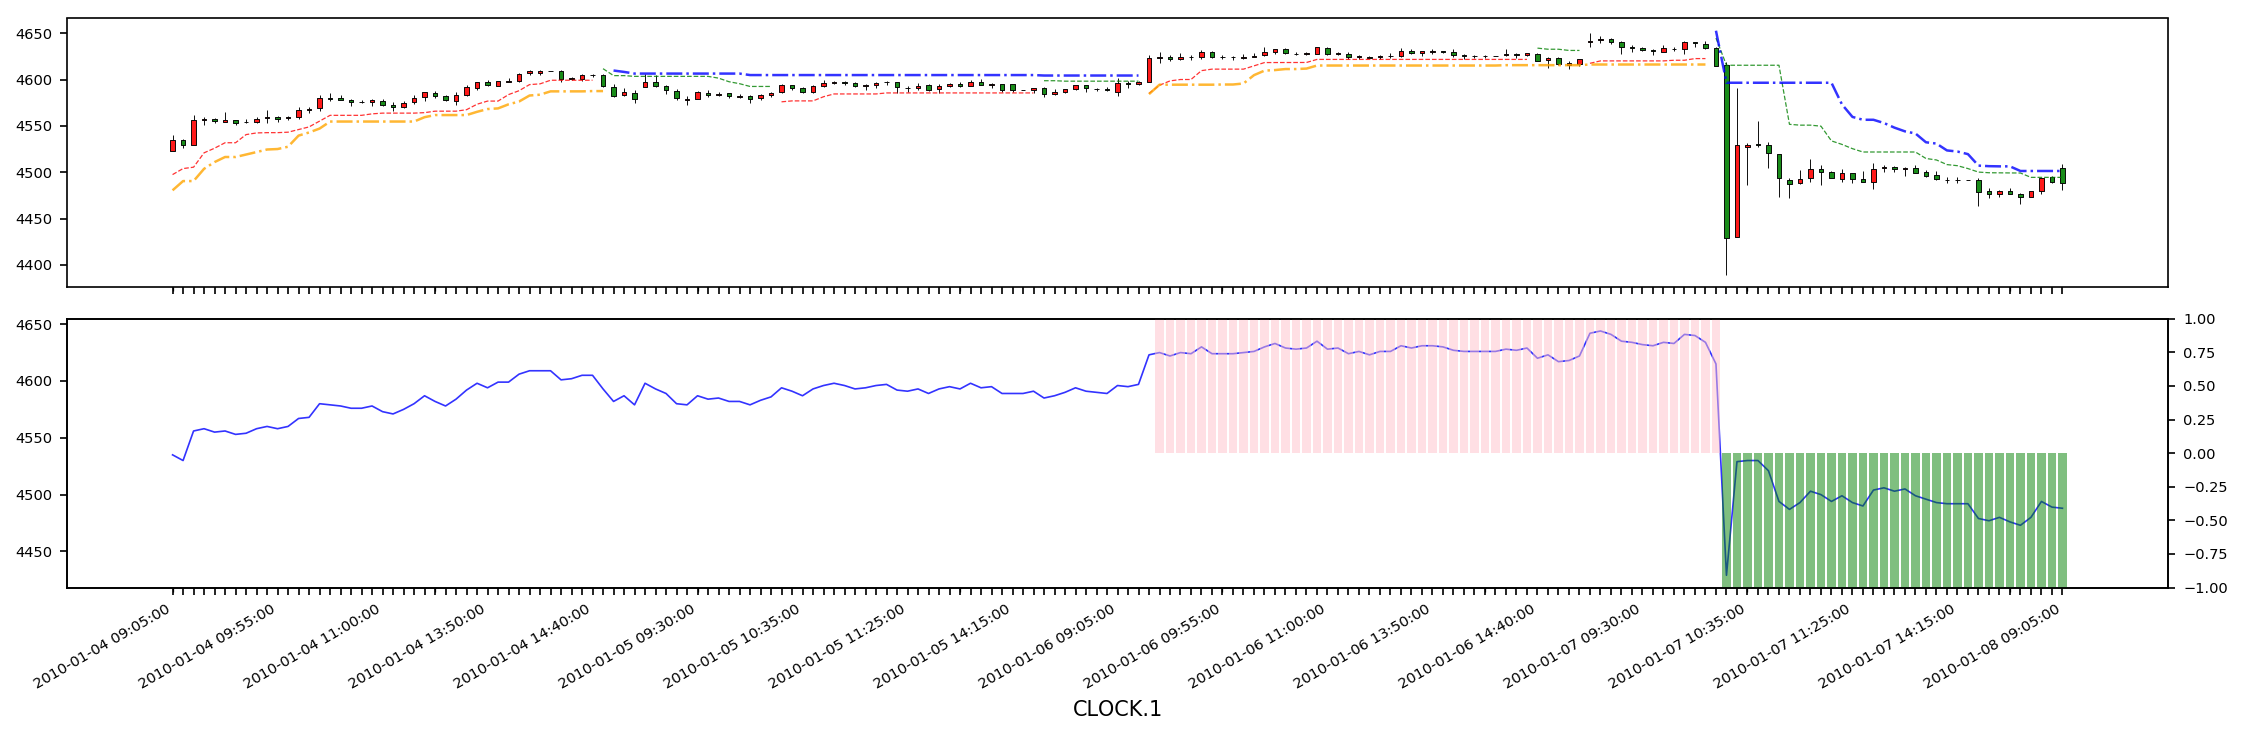

In [83]:
plot_all('rb', '2010-01-04 09:05:00', '2010-01-08 09:05:00')